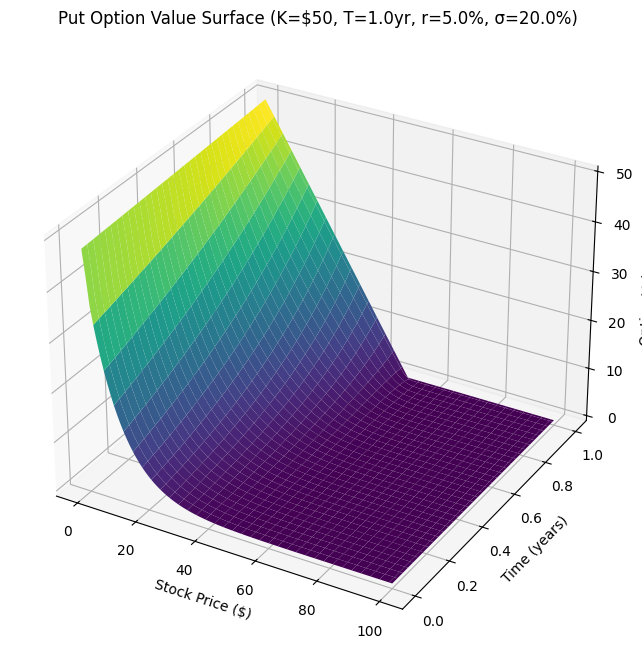

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from mpl_toolkits.mplot3d import Axes3D 

def black_scholes_cn(S_max, K, T, r, sigma, M, N):
    # S_max is the maximmum stock price for charting, K is the strike, T is the maturity date, r is the risk free rate, sigma is volatility, M is discretized time, N is discretized price
    dt = T / M #time step size
    dx = S_max / N #Stock price step size
    x = np.linspace(0, S_max, N+1)  # Stock prices from 0 to S_max
    t = np.linspace(0, T, M+1)      # Time points from 0 to T
    
    # Initialize option values matrix with size based on our linspace
    V = np.zeros((N+1, M+1))
    
    # Condition: At maturity time T, our option is either 0 or the strike minus the stock price. Selecting all rows from our last time column.
    V[:, -1] = np.maximum(K - x, 0)
    
    # Boundary conditions: At a very low stock value, we select all timestamps and calculate the discounted price of our option (which approaches K as t increases)
    V[0, :] = K * np.exp(-r * (T - t))  # S=0
    #At a very high stock value, in this case S_max we can deem our put worthless
    V[-1, :] = 0                        # S=S_max
    
    # Interior points for coefficients, we wish to exclude the boundary points
    j = np.arange(1, N)
    
    # Compute coefficients with crank nicholson scheme. These are solved for by hand.
    alpha = 0.5 * dt * (sigma**2 * x[j]**2 / dx**2 - r * x[j] / dx)
    beta = 1 + dt * (sigma**2 * x[j]**2 / dx**2 + r)
    gamma = 0.5 * dt * (sigma**2 * x[j]**2 / dx**2 + r * x[j] / dx)
    
    # Create matrices A and B using our diags function
    A = diags([-gamma, beta, -alpha], [-1, 0, 1], shape=(N-1, N-1)).tocsc()
    B = diags([gamma, 2 - beta, alpha], [-1, 0, 1], shape=(N-1, N-1)).tocsc()
    
    # We start at T, time at maturity and work our way backward. Known values from n+1 are used to solve n. We have to update our boundary conditions with gamma and alpha.
    for n in range(M-1, -1, -1):  
        v_known = V[1:-1, n+1]
        
        # Compute right-hand side
        rhs = B @ v_known
        
        # Add boundary conditions
        rhs[0] += gamma[0] * V[0, n]
        rhs[-1] += alpha[-1] * V[-1, n]
        
        # Solve system for the current time step
        V[1:-1, n] = np.linalg.solve(A.toarray(), rhs)
    
    return V, x, t

# Example usage
S_max = 100  # Maximum stock price
K = 50       # Strike price
T = 1.0      # Time to maturity (1 year)
r = 0.05     # Risk-free rate (5%)
sigma = 0.2  # Volatility (20%)
M = 100      # Time steps
N = 100      # Space steps

# Solve
V, x, t = black_scholes_cn(S_max, K, T, r, sigma, M, N)

# Create a 3D plot for the PDE solution
X, T_grid = np.meshgrid(x, t)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T_grid, V.T, cmap='viridis')

ax.set_xlabel('Stock Price ($)')
ax.set_ylabel('Time (years)')
ax.set_zlabel('Option Value ($)')
ax.set_title(f'Put Option Value Surface (K=${K}, T={T}yr, r={r*100}%, σ={sigma*100}%)')
plt.show()

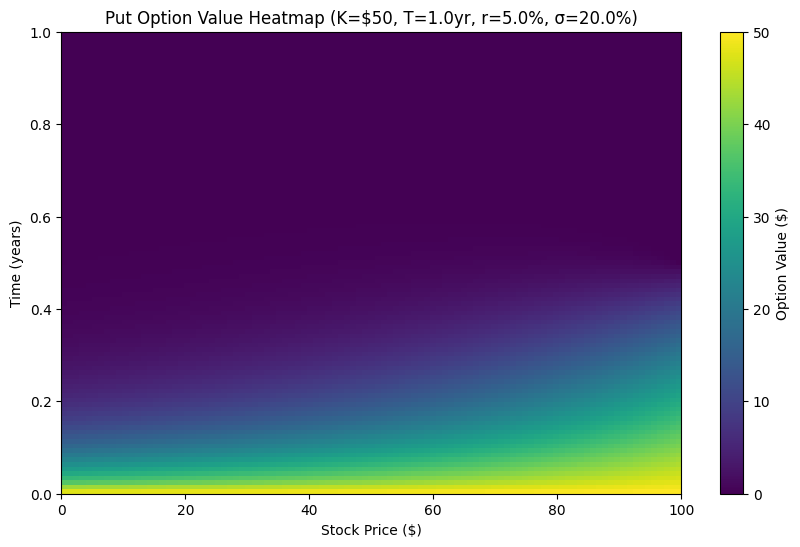

In [6]:
plt.figure(figsize=(10, 6))
plt.imshow(V, extent=[0, S_max, 0, T], origin='lower', aspect='auto', cmap='viridis')
plt.colorbar(label='Option Value ($)')
plt.xlabel('Stock Price ($)')
plt.ylabel('Time (years)')
plt.title(f'Put Option Value Heatmap (K=${K}, T={T}yr, r={r*100}%, σ={sigma*100}%)')
plt.show()